# Проект. Прогнозирование тональной окраски комментариев
## Глава 0. Входные данные

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В распоряжении набор данных с разметкой о токсичности правок.

Требуется модель со значением метрики качества *F1* не меньше 0.75. 

### Инструкция по выполнению проекта

1. Загрузить и подготовить данные.
2. Обучить разные модели. 
3. Сделайть выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

#### Путь к файлу:
- /datasets/toxic_comments.csv

### Описание данных

Признаки:  
- `text` — текст комментария  

Целевой признак:
- `toxic` — оценка токсичности комментария (1 - да, 0 - нет)

## Глава 1. Загрузка и подготовка данных

Вызовем основные библиотеки, необходимые для реализации проекта, более специфичные по ходу выполнения проекта:

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import seaborn as sns
import re
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')

Прочитаем файл, создадим ДатаФрейм, выведем таблицу:

In [138]:
#df = pd.read_csv('/datasets/toxic_comments.csv') # для загрузки из облака
df = pd.read_csv('toxic_comments.csv') # локально
df

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


Выведем информацию о таблице через метод `.info()`:

In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Посмотрим на распределение целевого признака, построив гистограмму и подсчитав уникальные значения(через методы `.hist()` и `.value_counts()` соответственно):

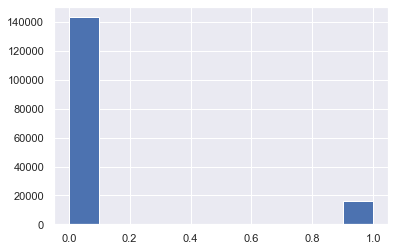

In [140]:
df['toxic'].hist();

In [141]:
df['toxic'].value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

Присутствует дисбаланс в целевом признаке. Количество токсичных комментариев значительно меньше. Необходимо это учеть при обучении моделей.

Прежде чем извлечь признаки из текста, упростим его.  
Воспользуемся Лемматизацией — приведение слова к начальной форме (лемме).  
Применим лемматизатор Wordnet из NLTK.

Вначале необходимо загрузить библиотеку и необходимые компоненты:

In [142]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Сергей\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [143]:
from nltk.corpus import wordnet

In [144]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Сергей\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

Для того, чтобы лемматизировать, нужно создать экземпляр WordNetLemmatizer() и вызвать функцию lemmatize()

In [145]:
from nltk.stem import WordNetLemmatizer 

Для того, чтобы найти правильный POS-тег для каждого слова, сопоставим его с правильным входным символом, который принимает WordnetLemmatizer, и передадим его в качестве второго аргумента в lemmatize().  
В nltk для этого есть метод nltk.pos_tag(). Он принимает список слов, а возвращает кортеж с тегом POS. Ключевым моментом здесь является сопоставление POS-тегов NLTK с форматом, принятым лемматизатором wordnet.

Воспользуемся готовыми и напишем функции для лемматизации текста:  
**get_wordnet_pos(word)** - возвращает  POS тэг для слова(к какой части речи относится слово)  
**clear_text(text)** - приводит к нижнему регистру и очишает от символом, кроме букв английского алфавита(через re)  
**lemmatize(text)** - проводит лемматизацию текста


In [146]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [147]:
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    lemm_list = nltk.word_tokenize(text)
    lemm_text = ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in lemm_list])      
    return lemm_text

In [148]:
def clear_text(text):
    clear_text = re.sub(r'[^a-zA-Z]', ' ', text)
    clear_text = clear_text.lower().split()
    return ' '.join(clear_text)

Проверим, что функции работают корректно на тексте первой строке обучающей выборки:

In [149]:
df.loc[0, 'text']

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [150]:
lemmatize(clear_text(df.loc[0, 'text']))

'explanation why the edits make under my username hardcore metallica fan be revert they weren t vandalism just closure on some gas after i vote at new york doll fac and please don t remove the template from the talk page since i m retire now'

Проведем лемматизацию для всего столбца:

In [151]:
%%time
df['lemm_text'] = df['text'].apply(lambda text: lemmatize(clear_text(text)))

Wall time: 1h 42min 18s


Выведем полученный результат и соотношение меток целевого признака в тестовой выборке:

In [152]:
df.head()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...


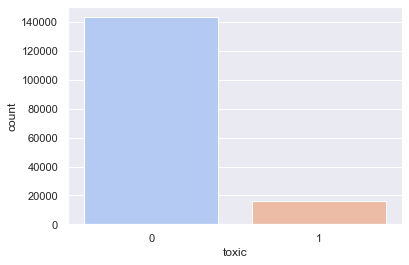

In [153]:
sns.countplot(x='toxic', data=df, palette='coolwarm');

Для того, чтобы сохранить результаты лемматизации и не запускать снова трудоемкий процесс, сохраним в csv и будем использовать его.

In [154]:
df.to_csv('lemm_toxic_comments.csv', index=False)

In [2]:
df = pd.read_csv('lemm_toxic_comments.csv')

Разделим датафрейм на 2 части: обучающую и тестовую выбороки в пропорциях 4:1, используя функцию `train_test_split` из библиетеки `sklearn.model_selection`  

In [3]:
train_features, test_features, train_target, test_target = train_test_split(
    df['lemm_text'], df['toxic'], test_size=0.25, random_state=17)

Выведем размеры матриц и векторов:

In [4]:
train_features.shape, test_features.shape, train_target.shape, test_target.shape

((119678,), (39893,), (119678,), (39893,))

Создададим корпуса слов для обучающей и тестовой выборок:

In [5]:
train_corpus = train_features.values.astype('U')
test_corpus = test_features.values.astype('U')

Чтобы почистить мешок слов, найдём стоп-слова. Используем пакет **stopwords**, который находится в модуле **nltk.corpus** библиотеки **nltk**

In [6]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Сергей\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
stop_words = set(stopwords.words('english'))

#### Вычислим TF-IDF для корпуса текстов

Рассчитать TF-IDF можно и в библиотеке **sklearn**. Класс `TfidfVectorizer()` в модуле **sklearn.feature_extraction.text**. Импортируем его:

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

Создадим счётчик, указав в нём стоп-слова, вызовем функцию `.fit_transform()` для обучающей выборки и `.transform()` для тестовой:

In [9]:
count_tf_idf = TfidfVectorizer(stop_words=stop_words)
train_tf_idf = count_tf_idf.fit_transform(train_corpus)
test_tf_idf = count_tf_idf.transform(test_corpus)

Выведем размеры получившихся матриц:

In [10]:
print("Размер обучающей матрицы:", train_tf_idf.shape), 
print("Размер тестовой матрицы:", test_tf_idf.shape)

Размер обучающей матрицы: (119678, 128432)
Размер тестовой матрицы: (39893, 128432)


Напишем функцию `scoring(fitted_model)` для определения метрики f1_score для тестовой выбороки:

In [11]:
def scoring(fitted_model):
    test_pred = fitted_model.predict(test_tf_idf)
    test_f1 = f1_score(test_target, test_pred)
    
    print('F1 на тестовой выборке: {:.3f}'.format(test_f1))

### Выводы по главе 1:

>В процессе загрузки и обработки данных обнаружили:
- В данных присутствовал дисбаланс целевого признака
- NLTK библиотека позволила преобразоваться тексты в векторный вид, пригодный для обучения моделей.
- TF-IDF существенно увеличил количество признаков, равное количеству в мешке слов.

## Глава 2. Обучение моделей

Обучим несколько моделей и оценим полученные результаты.  
Модели для обучения:
- **LogisticRegression**
- **XGBClassifier**
- **CatBoostClassifier**
- **LGBMClassifier**

Для подбора гиперпараметров импортируем **GridSearchCV**, для кросс-валидации при подборе гиперпараметров **ShuffleSplit**:

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

Стратегия кросс-валидации для подбора параметров:

In [13]:
cv = ShuffleSplit(n_splits=2, test_size=0.25, random_state=17)

#### 1. Обучим логистическую регресиию **LogisticRegression** как базовую модель

In [15]:
from sklearn.linear_model import LogisticRegression

In [22]:
log_reg = LogisticRegression(random_state=17, class_weight='balanced')

In [23]:
log_reg_params = {'C': np.linspace(0.0001, 100, 10)}

In [24]:
%%time
log_reg_grid = GridSearchCV(log_reg, log_reg_params, scoring='f1')
log_reg_grid.fit(train_tf_idf, train_target)

Wall time: 1min 54s


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=17, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.00000e-04, 1.11112e+01, 2.22223e+01, 3.33334e+01, 4.44445e+01,
       5.55556e+01, 6.66667e+01, 7.77778e+01, 8.88889e+01, 1.00000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [25]:
print('best parameters: ', log_reg_grid.best_params_)
print('best scores: ', log_reg_grid.best_score_)

best parameters:  {'C': 11.1112}
best scores:  0.7575399592857313


In [26]:
log_reg_grid.best_estimator_

LogisticRegression(C=11.1112, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=17, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Оценка F1_score: 

In [27]:
%%time
scoring(log_reg_grid.best_estimator_)

F1 на тестовой выборке: 0.761
Wall time: 18 ms


#### 2. Обучим модель градиентного бустинга  XGBClassifier

In [246]:
from xgboost import XGBClassifier

In [247]:
xgb_clf = XGBClassifier(random_state=17, n_jobs=-1)

In [248]:
xgb_clf_params = {'n_estimators': [100, 500]}

In [249]:
%%time
xgb_clf_grid = GridSearchCV(xgb_clf, xgb_clf_params, scoring='f1')
xgb_clf_grid.fit(train_tf_idf, train_target)

Wall time: 29min 29s


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_con...
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None,
                                     objective='binary:logistic',
                                     random_state=17, reg_alpha=None,
                                     reg_lambda=None, scal

In [250]:
print('best parameters: ', xgb_clf_grid.best_params_)
print('best scores: ', xgb_clf_grid.best_score_)

best parameters:  {'n_estimators': 500}
best scores:  0.7624070342646422


In [251]:
xgb_clf_grid.best_estimator_

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=17, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

Оценка F1_score: 

In [252]:
%%time
scoring(xgb_clf_grid.best_estimator_)

F1 на тестовой выборке: 0.775
Wall time: 805 ms


#### 3. Обучим модель градиентного бустинга  CatBoostClassifier

In [14]:
from catboost import CatBoostClassifier

In [17]:
train_target

86305     0
86000     0
122621    0
150823    0
128349    0
         ..
25631     0
125680    0
42297     0
34959     1
64753     0
Name: toxic, Length: 119678, dtype: int64

In [19]:
scale_pos_weight = round((len(train_target[train_target == 0]) / 
                          len(train_target[train_target == 1])), 3)
scale_pos_weight

8.857

In [22]:
CatBoost_clf = CatBoostClassifier(random_state=17, iterations=500, scale_pos_weight=scale_pos_weight)

In [23]:
%%time
CatBoost_clf.fit(train_tf_idf, train_target)

Learning rate set to 0.150069
0:	learn: 0.6282730	total: 2.65s	remaining: 22m 1s
1:	learn: 0.5867189	total: 4.68s	remaining: 19m 24s
2:	learn: 0.5611878	total: 6.07s	remaining: 16m 44s
3:	learn: 0.5478580	total: 7.29s	remaining: 15m 3s
4:	learn: 0.5333440	total: 8.49s	remaining: 14m
5:	learn: 0.5213615	total: 9.71s	remaining: 13m 19s
6:	learn: 0.5105712	total: 10.9s	remaining: 12m 46s
7:	learn: 0.5030787	total: 12.1s	remaining: 12m 22s
8:	learn: 0.4941392	total: 13.3s	remaining: 12m 4s
9:	learn: 0.4885992	total: 14.5s	remaining: 11m 49s
10:	learn: 0.4827064	total: 15.7s	remaining: 11m 36s
11:	learn: 0.4786722	total: 16.8s	remaining: 11m 25s
12:	learn: 0.4734499	total: 18s	remaining: 11m 15s
13:	learn: 0.4674460	total: 19.2s	remaining: 11m 7s
14:	learn: 0.4606905	total: 20.4s	remaining: 11m
15:	learn: 0.4572097	total: 21.7s	remaining: 10m 56s
16:	learn: 0.4536339	total: 23s	remaining: 10m 52s
17:	learn: 0.4499871	total: 24.3s	remaining: 10m 50s
18:	learn: 0.4463375	total: 25.6s	remainin

Оценка F1_score: 

In [24]:
%%time
scoring(CatBoost_clf)

F1 на тестовой выборке: 0.750
Wall time: 666 ms


#### 4. Обучим модель градиентного бустинга  LGBMClassifier

In [257]:
from lightgbm import LGBMClassifier

In [258]:
lgbm_clf = LGBMClassifier(n_jobs=-1, random_state=17, class_weight='balanced')

In [259]:
lgbm_clf_params = {'n_estimators': [500],
                   'learning_rate': [0.1, 0.3, 0.5]}

In [260]:
%%time
lgbm_clf_grid = GridSearchCV(lgbm_clf, lgbm_clf_params, scoring='f1')
lgbm_clf_grid.fit(train_tf_idf, train_target)

Wall time: 19min 47s


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt',
                                      class_weight='balanced',
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=17, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid={'learning_ra

In [261]:
print('best parameters: ', lgbm_clf_grid.best_params_)
print('best scores: ', lgbm_clf_grid.best_score_)

best parameters:  {'learning_rate': 0.1, 'n_estimators': 500}
best scores:  0.7531108305028578


In [262]:
lgbm_clf_grid.best_estimator_

LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=500, n_jobs=-1, num_leaves=31,
               objective=None, random_state=17, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

Оценка F1_score: 

In [263]:
%%time
scoring(lgbm_clf_grid.best_estimator_)

F1 на тестовой выборке: 0.762
Wall time: 3.21 s


## BERT

Начнем с загрузки необходимых библиотек:

In [45]:
from sklearn.model_selection import cross_val_score
from tqdm import notebook
import torch
import transformers as ppb

DistilBERT представляет собой уменьшенную версию BERT'а. Она быстрее и легче своего старшего собрата, но при этом вполне сравнима в результативности.

Загрузим предобученную модель DistilBERT и токенизатор:

In [46]:
model_class, tokenizer_class, pretrained_weights = (
    ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

In [47]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [65]:
df

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir be my hero any chance you remember wha...
...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,and for the second time of ask when your view ...
159567,You should be ashamed of yourself \n\nThat is ...,0,you should be ashamed of yourself that be a ho...
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,spitzer umm there no actual article for prosti...
159569,And it looks like it was actually you who put ...,0,and it look like it be actually you who put on...


Выполним токенезацию исходных текстов:

In [48]:
%%time
tokenized = df['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=df['text'].shape[0])))

Wall time: 4min 12s


Модель DistilBERT принимает максимальное количество токенов в тексте по умолчанию равное 512. Посчитаем длины текстов с токенами:

In [66]:
len_sentences = [len(i) for i in tokenized]

In [67]:
len_sentences = pd.Series(len_sentences)
len_sentences.describe()

count    159571.000000
mean         94.891860
std         141.438775
min           4.000000
25%          26.000000
50%          52.000000
75%         104.000000
max        4950.000000
dtype: float64

Видем что есть аномально длинные. Ограничим тексты максимальной длиной токенов 75% квантилем.

In [68]:
indexes = []
for i in notebook.tqdm(range(len(tokenized))):
    if len(tokenized[i]) <= len_sentences.quantile(.75):
        indexes.append(i)

In [69]:
len(indexes)

119975

Полученные индексы "коротких" текстов применим к Датафрейму:

In [186]:
filtered_df = df.query('index in @indexes')

Размеры ДатаФрейма:

In [187]:
filtered_df.shape

(119975, 3)

Разделим датафрейм на 2 части: обучающую и тестовую выбороки в пропорциях по умолчанию:

In [194]:
filtered_df_train, filtered_df_test = train_test_split(filtered_df, random_state=17, test_size=5000)

In [195]:
filtered_df_train.shape, filtered_df_test.shape

((114975, 3), (5000, 3))

Для того, чтобы сбалансировать метки целевого признака в обучающей выборке, воспользуемся техникой **downsampling** 

### Уменьшение выборки downsampling  
- Разделим обучающую выборку на отрицательные и положительные объекты
- Случайным образом отбросим часть из отрицательных объектов;
- С учётом полученных данных создадим новую обучающую выборку;
- Перемешаем данные. Положительные не должны идти следом за отрицательными: алгоритмам будет сложнее обучаться.

Посмотри на отнощение класса "1" к "0"

In [196]:
coef  = round((len(filtered_df_train[filtered_df_train['toxic'] == 1]) / 
               len(filtered_df_train[filtered_df_train['toxic'] == 0])), 3)
coef

0.127

Напишем функцию **downsample(features, target, fraction)** для формирования сблалансированной выборки:

In [197]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=17)] +
                                     [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=17)] +
                                     [target_ones])
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled,
                                                      random_state=17)
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(filtered_df_train['text'], filtered_df_train['toxic'], coef)

Выведем размеры получившихся выборок и распределение целевого признака в обучающей выборке:

In [198]:
features_downsampled.shape, target_downsampled.shape

((25946,), (25946,))

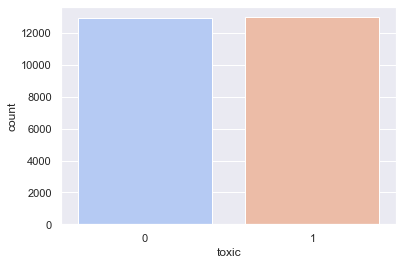

In [199]:
sns.set()
sns.countplot(target_downsampled, palette='coolwarm');

Объеденим снова в один ДатаФрейм обучающую выборку:

In [200]:
features_downsampled = pd.DataFrame(features_downsampled).reset_index(drop=True)
target_downsampled = pd.DataFrame(target_downsampled).reset_index(drop=True)
filtered_df_train = features_downsampled.join(target_downsampled)

In [201]:
filtered_df_train.shape, filtered_df_test.shape

((25946, 2), (5000, 3))

Эмбеддинги модель BERT создаёт батчами. Чтобы хватило оперативной памяти, сделаем размер батча небольшим (100). Обучающую выборку сделаем кратной размеру батча.

In [202]:
filtered_df_train = filtered_df_train[:25900]

Выполним токенезацию новых текстов:

In [203]:
%%time
tokenized_train = filtered_df_train['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=filtered_df_train['text'].shape[0])))

Wall time: 19.7 s


In [204]:
%%time
tokenized_test = filtered_df_test['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=filtered_df_test['text'].shape[0])))

Wall time: 3.86 s


Применим метод padding, чтобы после токенизации длины исходных текстов в корпусе были равными. Только при таком условии будет работать модель BERT. 

In [205]:
def padding(tokenized):
    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)

    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
    return padded

padded_train = padding(tokenized_train)
padded_test = padding(tokenized_test)

In [206]:
np.array(padded_train).shape, np.array(padded_test).shape

((25900, 104), (5000, 104))

Теперь поясним модели, что нули не несут значимой информации. Это нужно для компоненты модели, которая называется «внимание». Отбросим эти токены и «создадим маску» для действительно важных токенов, то есть укажем нулевые и не нулевые значения:

In [207]:
attention_mask_train = np.where(padded_train != 0, 1, 0)
attention_mask_test = np.where(padded_test != 0, 1, 0)
attention_mask_train.shape, attention_mask_test.shape

((25900, 104), (5000, 104))

Сделаем цикл по батчам. Отображать прогресс будет функция notebook()  
Преобразуем данные в формат тензоров  — многомерных векторов в библиотеке torch. Тип данных LongTensor хранит числа в «длинном формате», то есть выделяет на каждое число 64 бита.  
Чтобы получить эмбеддинги для батча, передадим модели данные и маску  
Для ускорения вычисления функцией no_grad() в библиотеке torch укажем, что градиенты не нужны: модель BERT обучать не будем.  
Из полученного тензора извлечём нужные элементы `batch_embeddings[0][:,0,:].numpy()` и добавим в список всех эмбеддингов  
Соберём все эмбеддинги в матрицу признаков вызовов функции `concatenate()`:

In [208]:
def embedings(padded, attention_mask):
    batch_size = 100
    embeddings = []
    for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
            batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
            attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])

            with torch.no_grad():
                batch_embeddings = model(batch, attention_mask=attention_mask_batch)

            embeddings.append(batch_embeddings[0][:,0,:].numpy())
    features = np.concatenate(embeddings)
    return features

In [210]:
features_train = embedings(padded_train, attention_mask_train)

In [211]:
features_test = embedings(padded_test, attention_mask_test)

Целевые признаки:

In [212]:
labels_train = filtered_df_train['toxic']
labels_test = filtered_df_test['toxic']

In [213]:
def scoring_BERT(fitted_model):
    test_pred = fitted_model.predict(features_test)
    test_f1 = f1_score(labels_test, test_pred)
    
    print('F1 на тестовой выборке: {:.3f}'.format(test_f1))

#### 1. Обучим Логистическую регрессию LogisticRegression:

In [216]:
log_reg = LogisticRegression(random_state=17)

In [217]:
log_reg_params = {'C': np.linspace(0.0001, 100, 10)}

In [218]:
%%time
log_reg_grid = GridSearchCV(log_reg, log_reg_params, scoring='f1')
log_reg_grid.fit(features_train, labels_train)

Wall time: 4min 44s


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=17, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': array([1.00000e-04, 1.11112e+01, 2.22223e+01, 3.33334e+01, 4.44445e+01,
       5.55556e+01, 6.66667e+01, 7.77778e+01, 8.88889e+01, 1.00000e+02])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [219]:
print('best parameters: ', log_reg_grid.best_params_)
print('best scores: ', log_reg_grid.best_score_)

best parameters:  {'C': 11.1112}
best scores:  0.8982250490907951


In [220]:
log_reg_grid.best_estimator_

LogisticRegression(C=11.1112, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=17, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Оценка F1_score: 

In [221]:
%%time
scoring_BERT(log_reg_grid.best_estimator_)

F1 на тестовой выборке: 0.690
Wall time: 28.9 ms


#### 2. Обучим модель градиентного бустинга  XGBClassifier

In [228]:
xgb_clf = XGBClassifier(random_state=17, n_jobs=-1, n_estimators=500)

In [229]:
%%time
xgb_clf.fit(features_train, labels_train)

Wall time: 12min 1s


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=17, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

Оценка F1_score: 

In [230]:
scoring_BERT(xgb_clf)

F1 на тестовой выборке: 0.676


#### 3. Обучим модель градиентного бустинга  CatBoostClassifier

In [231]:
CatBoost_clf = CatBoostClassifier(random_state=17, iterations=500)

In [232]:
%%time
CatBoost_clf.fit(features_train, labels_train)

Learning rate set to 0.078065
0:	learn: 0.6415097	total: 262ms	remaining: 2m 10s
1:	learn: 0.5955524	total: 485ms	remaining: 2m
2:	learn: 0.5568050	total: 707ms	remaining: 1m 57s
3:	learn: 0.5256337	total: 932ms	remaining: 1m 55s
4:	learn: 0.4973114	total: 1.16s	remaining: 1m 55s
5:	learn: 0.4739741	total: 1.39s	remaining: 1m 54s
6:	learn: 0.4553641	total: 1.61s	remaining: 1m 53s
7:	learn: 0.4395781	total: 1.84s	remaining: 1m 53s
8:	learn: 0.4262589	total: 2.06s	remaining: 1m 52s
9:	learn: 0.4137069	total: 2.29s	remaining: 1m 52s
10:	learn: 0.4025736	total: 2.52s	remaining: 1m 51s
11:	learn: 0.3922578	total: 2.74s	remaining: 1m 51s
12:	learn: 0.3836808	total: 2.97s	remaining: 1m 51s
13:	learn: 0.3760168	total: 3.19s	remaining: 1m 50s
14:	learn: 0.3684765	total: 3.42s	remaining: 1m 50s
15:	learn: 0.3619674	total: 3.65s	remaining: 1m 50s
16:	learn: 0.3563597	total: 3.87s	remaining: 1m 50s
17:	learn: 0.3514805	total: 4.09s	remaining: 1m 49s
18:	learn: 0.3464721	total: 4.32s	remaining: 1m 

Оценка F1_score: 

In [233]:
scoring_BERT(CatBoost_clf)

F1 на тестовой выборке: 0.675


#### 4. Обучим модель градиентного бустинга  LGBMClassifier

In [222]:
lgbm_clf = LGBMClassifier(n_jobs=-1, random_state=17)

In [223]:
lgbm_clf_params = {'n_estimators': [500],
                   'learning_rate': [0.1, 0.3, 0.5]}

In [224]:
%%time
lgbm_clf_grid = GridSearchCV(lgbm_clf, lgbm_clf_params, scoring='f1')
lgbm_clf_grid.fit(features_train, labels_train)

Wall time: 11min 35s


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=17, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [0.1, 0.3, 0.5],
                      

In [225]:
print('best parameters: ', lgbm_clf_grid.best_params_)
print('best scores: ', lgbm_clf_grid.best_score_)

best parameters:  {'learning_rate': 0.5, 'n_estimators': 500}
best scores:  0.8977265596183712


In [226]:
lgbm_clf_grid.best_estimator_

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.5, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
               random_state=17, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Оценка F1_score: 

In [227]:
%%time
scoring_BERT(lgbm_clf_grid.best_estimator_)

F1 на тестовой выборке: 0.674
Wall time: 147 ms


#### Проверка модели на вменяемость
Для того, чтобы получить «случайные» результаты, воспользуемся DummyClassifier. Полученные им результаты абсолютно случайные.  

In [237]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier()

In [238]:
scores = cross_val_score(dummy_clf, features_train, labels_train, scoring='f1')
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Dummy classifier score: 0.495 (+/- 0.01)


In [239]:
dummy_clf.fit(features_train, labels_train)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

Оценка F1_score: 

In [240]:
scoring_BERT(dummy_clf)

F1 на тестовой выборке: 0.165


Видим что в среднем модель предсказывает 50/50. Что гораздо хуже рассмотренных выше моделей.

### Выводы по главе 2:

> В процессе обучения моделей обнаружили по TF-IDF:
- Почти все модели показали значение f1 в районе 0.76.
- Лучшей по метрики f1 является Логистическая XGBClassifier
- Лучшей по времени обучения Логистическая Регрессия

>  В процессе обучения моделей по BERT:
- Почти все модели показали значение f1 в районе 0.67
- Лучшей также является Логистическая Регрессия c результатом 0.69

## Глава 3. Анализ моделей и общий вывод

Проанализируем все модели на качество предсказания, скорость обучения

Сведем все данные в таблицу:

In [29]:
data = {'Модель':['LogisticRegression', 'XGBClassifier', 'CatBoostClassifier', 'LGBMClassifier'], 
        'Скорость обучения':['Очень высокая', 'Высокая', 'Высокая', 'Очень высокая'],
        'Качество предсказания по TF-IDF': [0.761, 0.775, 0.75, 0.76],
        'Качество предсказания по BERT': [ 0.69, 0.676, 0.675, 0.674]}

In [30]:
df1 = pd.DataFrame(data)
df1

,Модель,Скорость обучения,Качество предсказания по TF-IDF,Качество предсказания по BERT
0,LogisticRegression,Очень высокая,0.761,0.690
1,XGBClassifier,Высокая,0.775,0.676
2,CatBoostClassifier,Высокая,0.750,0.675
3,LGBMClassifier,Очень высокая,0.760,0.674


### Общий вывод:

> По результатам исследований моделей для поставленной задачи наиболее оптимальными являются:
- **LogisticRegression**  

>**LogisticRegression** -  базовая модель, показывает хорошие показатели метрик и скорости обучения и предсказания, очень проста в настройке и не требует особой настройки гиперпараметров по сетке. Очень хорошо работает с предобработанными данными, т.е. после TF-IDF.     
В целом все модели дают хорошие показатели метрики, но по скорости обучения отличаются.

> Представление текста в векторную форму через BERT проще, т.к. не требует предварительной лемматизации, но есть свои особенности в настройки модели. 

>Для данной задачи лучшая для заказчика в плане качества предсказания, скорости предсказания, время обучения - **LogisticRegression**.     
Т.к. лучше всего работает с предобработанными данными и имеет самую высокую скорость обучения, как все линейные модели.  